# Clustering of 3k PBMCs sequenced by 10X scRNA-seq

First, load dependencies. 

In [46]:
import sys
sys.path.append("./")
import pandas as pd
import numpy as np
from settings import settings, paths
import os
import muffin
import scanpy as sc

You can set plot settings for muffin :

In [47]:
muffin.params["autosave_plots"] = "3k_pbmc/"
muffin.params["figure_dpi"] = 96
muffin.params["autosave_format"] = ".pdf"
sc.set_figure_params(dpi=96, dpi_save=500)
sc.set_figure_params(dpi=96, dpi_save=500)
sc.settings.autosave = True
sc.settings.figdir = "3k_pbmc/"
# Makes pdf font editable with pdf editors
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/shared/projects/pol2_chipseq/pkg/miniconda3/envs/muffin_test/lib/python3.10/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


We can load the dataset using scanpy functions, however muffin does not support sparse matrices :

In [48]:
dataset = sc.datasets.pbmc3k()
dataset.X = dataset.X.astype(np.int32).toarray()

The dataset is in an anndata object, which allows for an easy annotation of the count matrix, and the storage of different count transforms. Results will be stored in this object.

In [49]:
print(dataset)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


Here, we perform some standard QC (counts, percentage of mitochondrial RNA, number of detected genes...) on cells to remove low quality cells.

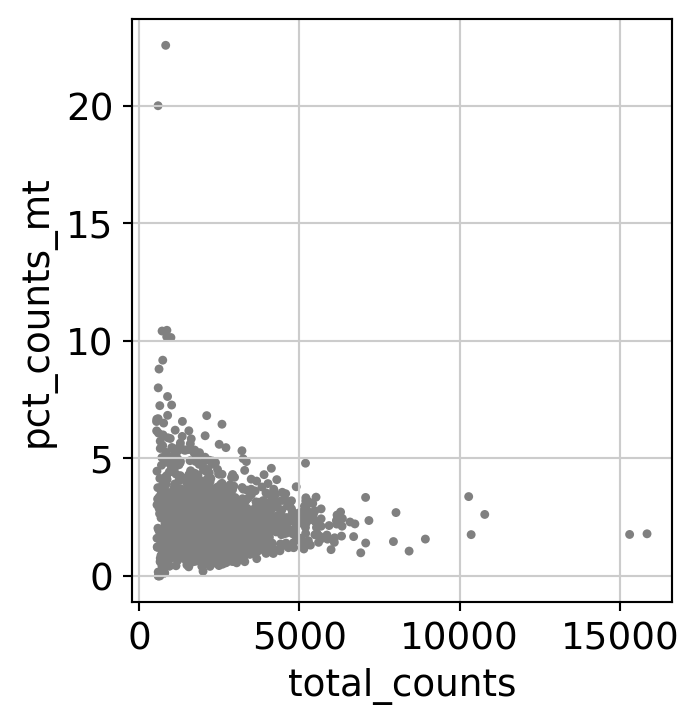

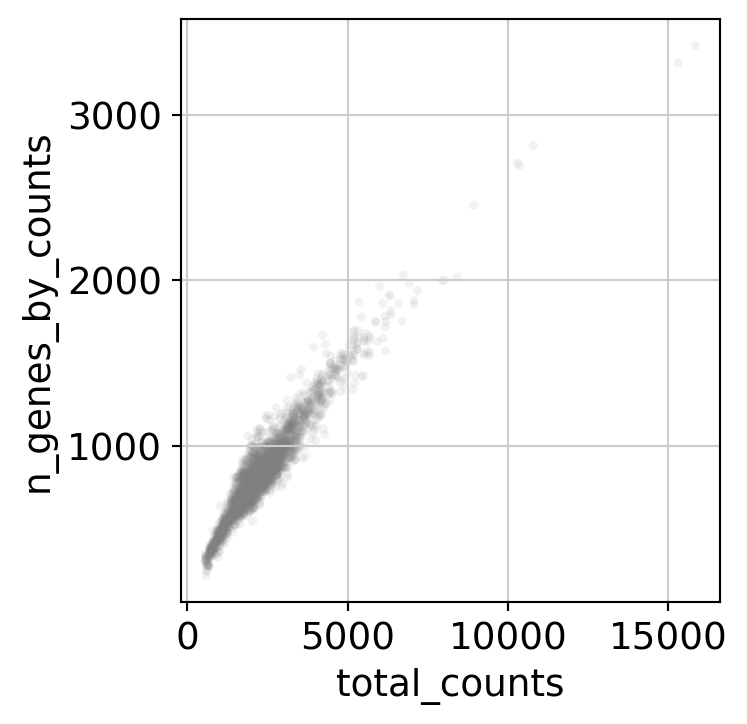

In [50]:
dataset.var['mt'] = dataset.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(dataset, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.scatter(dataset, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(dataset, x='total_counts', y='n_genes_by_counts', alpha=0.1)
# Same cutoffs as Seurat
dataset = dataset[dataset.obs.pct_counts_mt < 5, :]
dataset = dataset[dataset.obs.n_genes_by_counts < 2500, :]
dataset = dataset[dataset.obs.n_genes_by_counts > 200, :]

In [51]:
total_per_cell = np.sum(dataset.X, axis=1)
ds_2x = sc.pp.downsample_counts(dataset, (total_per_cell*0.25).astype(int), copy=True)


In [52]:
dataset = dataset.concatenate(ds_2x)

Here, we set up the design matrix of the linear model. If you do not want to regress any confounding factors leave it to a column array of ones as in the example. Note that it can have a tendency to "over-regress" and remove biological signal as it is a simple linear correction.

In [53]:
design = np.ones((dataset.X.shape[0],1))
muffin.load.set_design_matrix(dataset, design)

In [54]:
dataset

AnnData object with n_obs × n_vars = 5276 × 32738
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'design'

Now, we are going to normalize library sizes using the scran approach, which is well suited to a large number of observations and small counts with many zeroes. We are also going to remove features with very low signal (note that this is mandatory to remove all zero counts).

In [55]:
detectable = muffin.tools.trim_low_counts(dataset)
dataset = dataset[:, detectable]
muffin.tools.compute_size_factors(dataset, "scran")

AnnData object with n_obs × n_vars = 5276 × 14105
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'size_factors'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'design'

The next step is to fit the mean-variance relationship and compute residuals to the fitted Negative Binomial model.

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 832 tasks      | elapsed:   14.7s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:   20.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done 11544 tasks      | elapsed:   21.9s
[Parallel(n_jobs=8)]: Done 14105 out of 14105 | elapsed:   23.9s finished


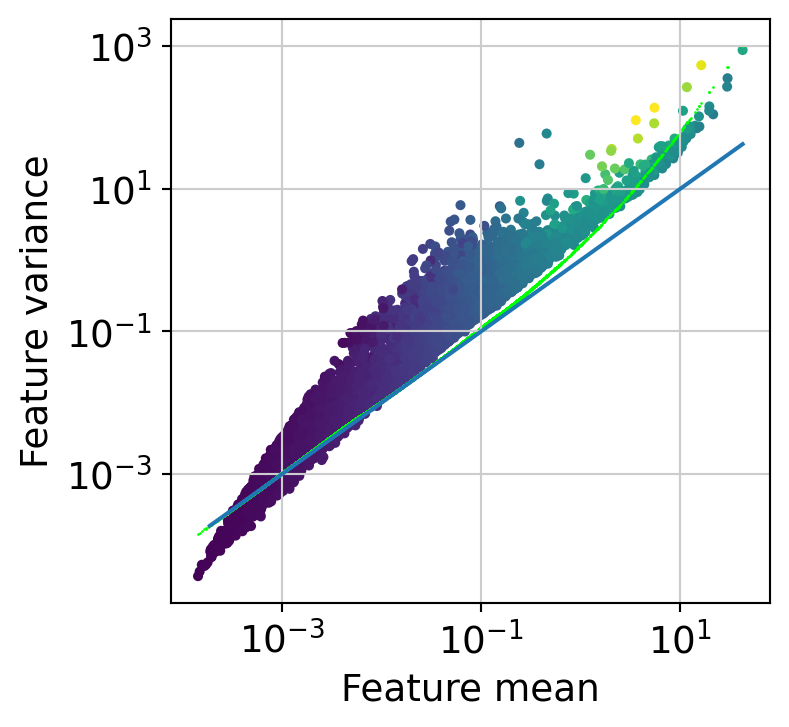

AnnData object with n_obs × n_vars = 5276 × 14105
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'size_factors'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'means', 'variances', 'reg_alpha'
    obsm: 'design'
    layers: 'residuals'

In [56]:
muffin.tools.compute_residuals(dataset, maxThreads=8)

Next, we perform dimensionnality reduction with PCA (automatically finding the optimal dimensionnality) and UMAP.

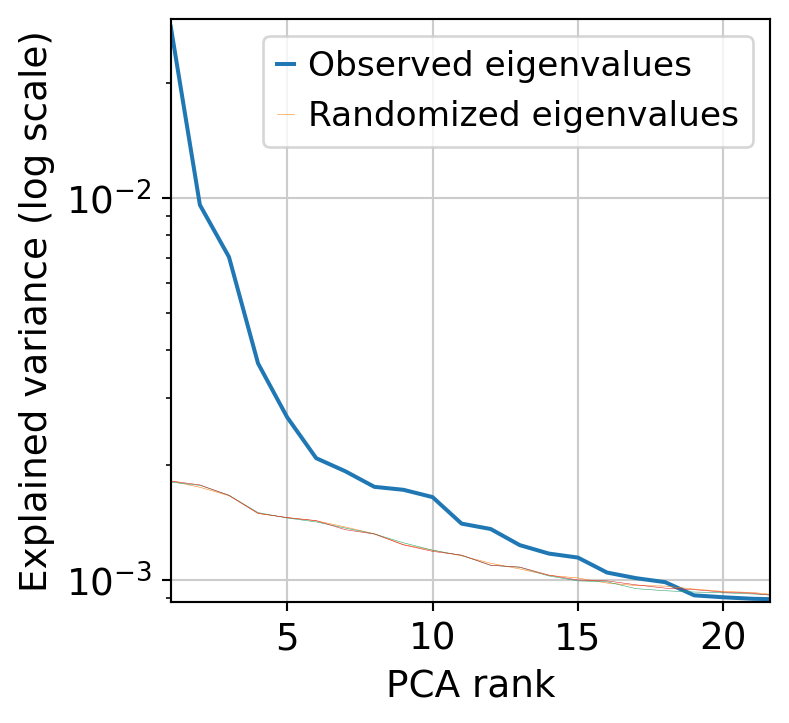

In [57]:
muffin.tools.compute_pa_pca(dataset, max_rank=50, plot=True)
sc.tl.tsne(dataset)

Now, cluster the cells.

Display the results. Note that we can use scanpy functions here!

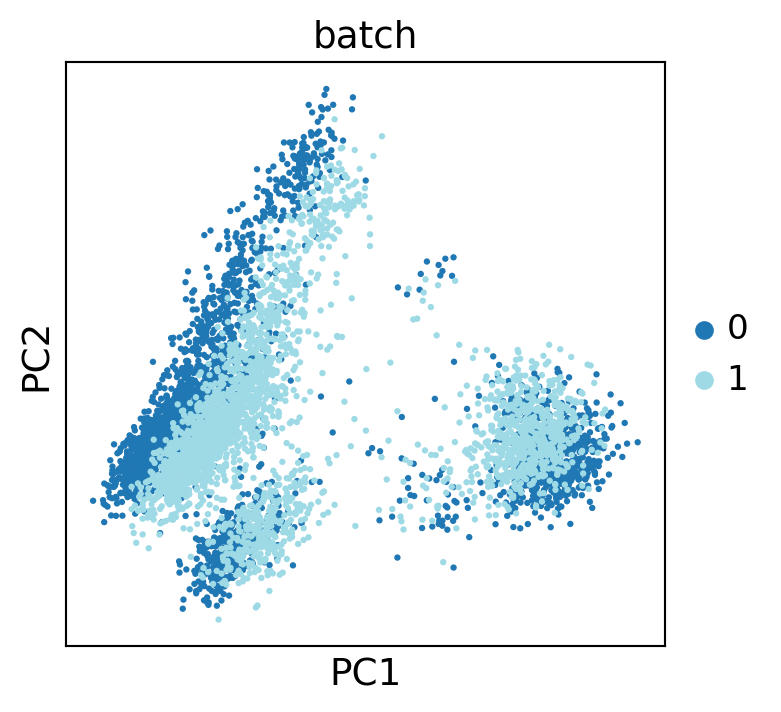

In [58]:
# Append cell type info to the dataset
sc.pl.pca(dataset, color='batch', save="residuals025.pdf", palette="tab20")


In [59]:
from sklearn.preprocessing import StandardScaler
# Targets 10000.0 total counts as per standard scRnaseq pipelines
countsum = np.sum(dataset.X, axis=1)/10000.0
dataset.layers["scaled_logcpm"] = StandardScaler().fit_transform(np.log1p(dataset.X/countsum[:, None]))

In [60]:
muffin.tools.compute_pa_pca(dataset, max_rank=50, layer="scaled_logcpm")
sc.tl.tsne(dataset)

WARNING, estimated number of components is equal to maximal number of computed components !
 Try to rerun with higher max_rank.


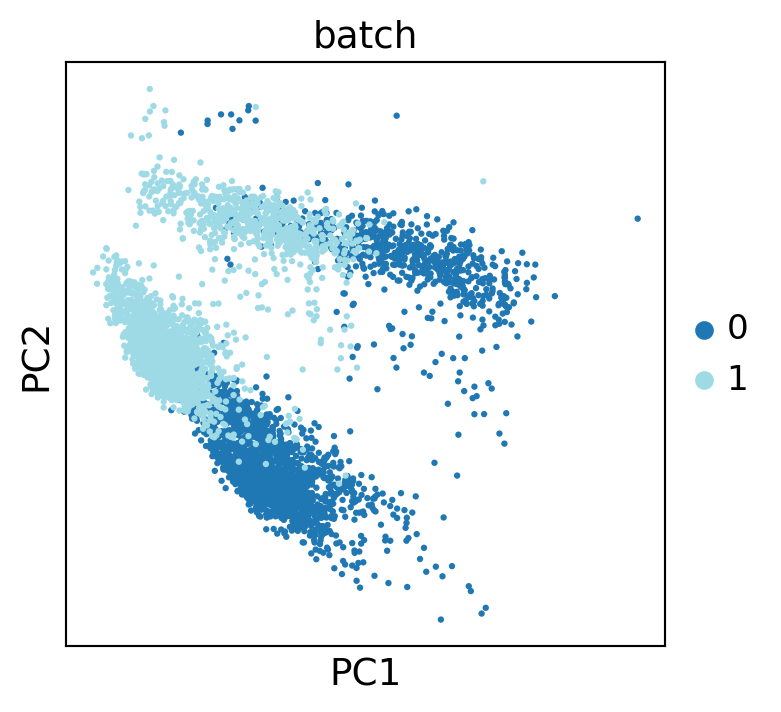

In [61]:
sc.pl.pca(dataset, color='batch', save="logcpm025.pdf", palette="tab20")